In [1]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.geocoders import AzureMaps
from geopy.geocoders import Bing
from geopy.geocoders import HereV7
from geopy.distance import geodesic
import time
import numpy as np
from matplotlib import pyplot as plt
import joblib
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split


# Differntially Private Models
from diffprivlib.models import PCA as DPPCA
from diffprivlib.models import standard_scaler as DPStandardScaler
from diffprivlib.models import GaussianNB as DPGaussianNB
from diffprivlib.models import LogisticRegression as DPLogisticRegression
from diffprivlib.models import RandomForestClassifier as DPRandomForestClassifier


# Non Private Models/PreProcessors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample

from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, log_loss,roc_auc_score,average_precision_score,recall_score,f1_score,precision_score

from sklearn.tree import plot_tree # draw a classification tree
from sklearn.model_selection import cross_val_score # cross validation
from sklearn.metrics import confusion_matrix # creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix

import shap

from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder

from sklearn.preprocessing import KBinsDiscretizer

from dtreeviz.trees import dtreeviz # remember to load the package

import seaborn as sns
import copy

from matplotlib import cm
import matplotlib.colors as col
from mpl_toolkits.mplot3d import Axes3D



import warnings
warnings.filterwarnings("ignore")

# Peek at Original Data

In [2]:
# Load Asset Location Data
asset_location_data = pd.read_excel('C:\\Users\\ZankarSS\\Downloads\\david_au_customer_data.xlsx')

# Clean Fraud Identifier Column/ Remove nan values
asset_location_data['Known Fraud'] = [0 if elem is np.nan else 1 for elem in asset_location_data['Known Fraud']]

print("Fraud Value Counts: ")
print(asset_location_data['Known Fraud'].value_counts())

print("Dataset Size:")
print(asset_location_data.shape)


Fraud Value Counts: 
0    114862
1        88
Name: Known Fraud, dtype: int64
Dataset Size:
(114950, 20)


# Non-Geo Features

In [3]:
mapping = {
  'Null': 'Unknown',
  np.nan: 'Unknown',
  'Other': 'Unknown',
  'Company (New Zealand)': 'Company',
  'Sole Trader (As Trustee for)': 'Sole Trader as Trustee',
  'Club (Ltd)': 'Club',
  'Association (Ltd)': 'Association',
}

asset_location_data['Customer Type'] = asset_location_data['Customer Type'].map(mapping).fillna(asset_location_data['Customer Type'])
# asset_location_data['Customer_Type_Cleaned'].value_counts(dropna=False)

In [4]:
mapping = {
  'COMMERCIAL': 'Commercial',
  'COM': 'Commercial',
  np.nan: 'Unknown',
  'Null': 'Unknown',
  'GOVT': 'Govt',
}

asset_location_data['Scorecard Type'] = asset_location_data['Scorecard Type'].map(mapping).fillna(asset_location_data['Scorecard Type'])
# asset_location_data['Scorecard_Type_Cleaned'].value_counts(dropna=False)

In [5]:
### define input/output features ###
classifier_target = ['Known Fraud']
classifier_input_cat = ['Customer Type','Business Unit','Equipment Type','Scorecard Type','Equipment Address']
classifier_input_num = ['Equipment Cost']


In [6]:
### Remove samples with na values ###
asset_location_data = asset_location_data[classifier_input_num+classifier_input_cat+classifier_target].dropna()

### type conversion ###
asset_location_data[classifier_input_cat] = asset_location_data[classifier_input_cat].astype(str)
asset_location_data[classifier_input_num] = asset_location_data[classifier_input_num].astype(float)

### Separate fraud and non-fraud cases into different dataframes
fraud_df = asset_location_data[asset_location_data['Known Fraud'] == 1]
non_fraud_df = asset_location_data[asset_location_data['Known Fraud'] == 0]

# parition dataset by prediction class
asset_location_data_majority = non_fraud_df
asset_location_data_minority = fraud_df

# asset_location_data_minority_upsampled = resample(asset_location_data_minority, 
#                                  replace=True,     # sample with replacement
#                                  n_samples=500,    # to match majority class
#                                  random_state=50) # reproducible results

asset_location_data_majority_downsampled = resample(asset_location_data_majority, 
                                 replace=True,     # sample with replacement
                                 n_samples=5000,    # to match majority class
                                 random_state=50) # reproducible results

 
# Combine downsampled majority class with upsampled minority class
asset_location_data = pd.concat([asset_location_data_majority_downsampled, asset_location_data_minority])

# enc = OrdinalEncoder()

# asset_location_data[[elem for elem in classifier_input if elem!= 'Equipment Address']] = enc.fit_transform(asset_location_data[[elem for elem in classifier_input if elem!= 'Equipment Address']])
asset_location_data = asset_location_data.reset_index(drop=True)

# Geo Features

In [7]:
## FETCH AND STORE GEOLOCATION DATA FOR ALL UNIQUE ADDRESSES
unique_asset_addresses = asset_location_data['Equipment Address'].unique()
unique_asset_addresses =  pd.Series(unique_asset_addresses).values
unique_asset_addresses.shape

(4364,)

In [8]:

# # # # instantiate geolocators # # #
# geolocator_nominatim = Nominatim(user_agent="address_check")
# geolocator_bing = Bing(api_key='Amb8Un7wV0bWGrejsJ-V2oQNV6fLLptHGXWq2ezeY3LhKg2Jxo9kdpbPSnVsyMA-')
# geolocator_herev7 = HereV7(apikey='11YmxZJmF5r-933qB-C0BLwsg4V2df-yjJLrqnvyoSE', user_agent='address_check')

# # # dictionary to store corresponding api call result for each unique address
# asset_address_info_dict = dict()

# # # # iterate through each unique address to make api call and store returned result in dictionary
# # # # WARNING! Time required: ~40 mins
# counter = 0 

# for address in unique_asset_addresses:    
#   nominatim_location = geolocator_nominatim.geocode(address, timeout=20) 
#   bing_location = geolocator_bing.geocode(address,timeout=20)
#   here_location = geolocator_herev7.geocode(address,timeout=20)

#   asset_address_info_dict[address] = dict()

#   if nominatim_location is None:
#     asset_address_info_dict[address]['nominatim'] = 'Not Available'

#   if nominatim_location is not None:
#     asset_address_info_dict[address]['nominatim'] = nominatim_location.raw

#   if bing_location is None:
#     asset_address_info_dict[address]['bing'] = 'Not Available'

#   if bing_location is not None:
#     asset_address_info_dict[address]['bing'] = bing_location.raw

#   if here_location is None:
#     asset_address_info_dict[address]['here'] = 'Not Available'

#   if here_location is not None:
#     asset_address_info_dict[address]['here'] = here_location.raw

#   counter+=1
#   print(counter)


# # # length of generated address info dictionary
# len(asset_address_info_dict)

# # # save dicionary as pickle file
# joblib.dump(asset_address_info_dict,'au_unique_asset_address_info_dict.pickle')
# # write_pickle_object(asset_address_info_dict, 'tm-ai/FraudDetection/Wayne/Asset_Experiment/address_info_dict_nominatim.pickle')

# read saved asset address dictionary pickle file
asset_address_info_dict  = joblib.load('au_unique_asset_address_info_dict.pickle')


In [9]:
len(asset_address_info_dict)

4364

In [10]:

asset_location_data['Postcode'] = pd.Series([elem.split(' ')[-2] if elem.split(' ')[-2] != 'NEW' else elem.split(' ')[-3]  for elem in asset_location_data['Equipment Address'] ])


mapping = {
  'place_house':'residential',
  'highway_tertiary':'highway_establishment',
  'building_yes':'building',
  'highway_residential':'residential',
  'building_house':'residential',
  'highway_primary':'highway_establishment',
  'office_company':'commercial',
  'building_apartments':'residential',
  'highway_trunk':'highway_establishment',
  'highway_secondary':'highway_establishment',
  'building_office':'commercial',
  'highway_trunk':'highway_establishment',
  'building_industrial':'highway_establishment',
  'highway_unclassified':'highway_establishment',
  'building_residential':'residential',
  'office_yes':'commercial',  
  np.nan: 'Unknown',
  'Null': 'Unknown'
}

asset_location_data['asset_address_type_nominatim'] = pd.Series([asset_address_info_dict[elem]['nominatim']['class'] +'_' + asset_address_info_dict[elem]['nominatim']['type'] if type(asset_address_info_dict[elem]['nominatim']) == dict else 'Not Available' for elem in asset_location_data['Equipment Address']])
for elem in mapping.keys():
    asset_location_data['asset_address_type_nominatim'].replace(elem,mapping[elem],inplace=True)


asset_location_data['asset_address_type_bing'] = pd.Series([asset_address_info_dict[elem]['bing']['entityType'] if type(asset_address_info_dict[elem]['bing']) == dict else 'Not Available' for elem in asset_location_data['Equipment Address']])

asset_location_data['asset_address_type_here'] = pd.Series([asset_address_info_dict[elem]['here']['resultType'] if type(asset_address_info_dict[elem]['here']) == dict else 'Not Available' for elem in asset_location_data['Equipment Address']])

# # # Flag 1 : Residential Address Flag # # #
asset_location_data['residential_address_flag'] = pd.Series([1 if elem == 'residential' else 0  for elem in asset_location_data['asset_address_type_nominatim']])

# # # Flag 2 : High Risk Area Postcode Flag # # #

high_risk_postcodes = [2759, 2766,2770,3024,3038,3058,3059,3066,3109,4868,3064,2165,2164,4034,3029,4305,5062,2170,2194,
2165,2170,2216,3029,3029,2762,2176,2165,2160,2142,5095,2257,3021,3030,3805,3750,2200,2197,2170,2160,2145,2166,
2144,2142,2037,2026,2460,2135,2220]
high_risk_postcodes = [str(elem) for elem in high_risk_postcodes]

asset_location_data['high_risk_postcode_flag'] = pd.Series([1 if elem in high_risk_postcodes else 0 for elem in asset_location_data['Postcode']])

# Define Geo-Features List
classifier_input_cat_geo = ['Postcode','asset_address_type_nominatim','asset_address_type_bing','asset_address_type_here','residential_address_flag','high_risk_postcode_flag']

classifier_input_cat = classifier_input_cat + classifier_input_cat_geo

In [11]:
# asset_location_data.to_excel('data.xlsx')

# Exploratory Data Analysis:

In [12]:
def get_feat_dist(feat_list=classifier_input_cat,feat_value=0):
        plt.subplot(1,2,1)
        asset_location_data[asset_location_data['Known Fraud'] == 1][feat_list[feat_value]].value_counts(normalize=True)[:].plot(kind='bar',figsize=(15,5),title='Column '+str(feat_value)+' (Fraud Cases)',rot=90,ylabel='% Prevalence',xlabel='Value')
        plt.subplot(1,2,2)
        asset_location_data[asset_location_data['Known Fraud'] == 0][feat_list[feat_value]].value_counts(normalize=True)[:].plot(kind='bar',figsize=(15,5),title='Column ' +str(feat_value)+' (Non-Fraud Cases)',rot=90,ylabel='% Prevalence',xlabel='Value')
        plt.figure(figsize=(10,4))

In [13]:
# get_feat_dist(feat_list=classifier_input_num,feat_value=0)

<AxesSubplot:title={'center':'Column 0 (Non-Fraud Cases)'}, ylabel='Frequency'>

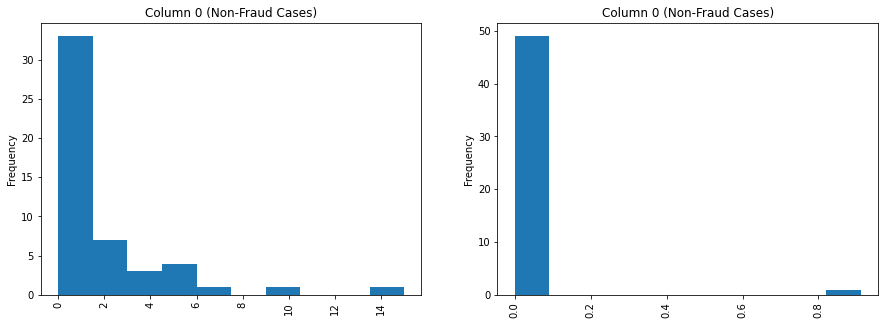

In [14]:
feat_list = classifier_input_num
feat_value = 0

plt.subplot(1,2,1)
asset_location_data[asset_location_data['Known Fraud'] == 1][feat_list[feat_value]].value_counts(normalize=False,bins=50)[:].plot(kind='hist',figsize=(15,5),title='Column ' +str(feat_value)+' (Non-Fraud Cases)',rot=90,ylabel='% Prevalence',xlabel='Value')
plt.subplot(1,2,2)
asset_location_data[asset_location_data['Known Fraud'] == 0][feat_list[feat_value]].value_counts(normalize=True,bins=50)[:].plot(kind='hist',figsize=(15,5),title='Column ' +str(feat_value)+' (Non-Fraud Cases)',rot=90,ylabel='% Prevalence',xlabel='Value')


# Final Preprocessing Before Model Training

In [15]:
classifier_target

['Known Fraud']

In [16]:
classifier_input_num

['Equipment Cost']

In [17]:
classifier_input_cat

['Customer Type',
 'Business Unit',
 'Equipment Type',
 'Scorecard Type',
 'Equipment Address',
 'Postcode',
 'asset_address_type_nominatim',
 'asset_address_type_bing',
 'asset_address_type_here',
 'residential_address_flag',
 'high_risk_postcode_flag']

In [18]:

# Define Input and Target DF #
X = asset_location_data[classifier_input_cat+classifier_input_num]
y = asset_location_data[classifier_target]
features = X.columns

# Split Into Train and Test Data to Prevent Information Leakage #
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# Ordinal Encoding for Categorical Features #
enc = OrdinalEncoder()
enc.fit(X[classifier_input_cat])

X_train[classifier_input_cat] = enc.transform(X_train[classifier_input_cat])
X_test[classifier_input_cat] = enc.transform(X_test[classifier_input_cat])

# Standard Scaling for Numerical Features #
std = StandardScaler()

X_train[classifier_input_num] = std.fit_transform(X_train[classifier_input_num])
X_test[classifier_input_num] = std.transform(X_test[classifier_input_num])



# Fraud Modelling

In [19]:
# Naive Bayes Model
nb = GaussianNB()

# lr = LogisticRegression(random_state=42)

rf = RandomForestClassifier(random_state=42)

dt = DecisionTreeClassifier(random_state=42)

ada = AdaBoostClassifier(random_state=42)

knn = KNeighborsClassifier()

# lin_svm = SVC(kernel="linear", C=0.025)

rbf_svm = SVC(gamma=2, C=1,probability=True)

nb.fit(X_train,y_train)
# lr.fit(X_train,y_train)
rf.fit(X_train,y_train)
dt.fit(X_train,y_train)
ada.fit(X_train,y_train)
knn.fit(X_train,y_train)
# lin_svm.fit(X_train,y_train)
rbf_svm.fit(X_train,y_train)



models = {'Random Forest': rf,'AdaptiveGB':ada,'Naive Bayes':nb,'Decision Tree':dt,'KNeighbors':knn,'RBF SVM':rbf_svm}

# RandomForest Model


In [26]:
models['AdaptiveGB'].estimator_errors_

array([0.01745329, 0.23748838, 0.28812249, 0.25533305, 0.29357874,
       0.31476273, 0.33596191, 0.27048412, 0.24881584, 0.31518737,
       0.33840853, 0.3025601 , 0.28076056, 0.33334496, 0.415788  ,
       0.36682768, 0.35352397, 0.41234087, 0.37967262, 0.3837379 ,
       0.39348419, 0.41660404, 0.43717918, 0.42696572, 0.43962957,
       0.40848277, 0.39608566, 0.46510429, 0.43019175, 0.43675269,
       0.43899661, 0.42814737, 0.39923364, 0.42026392, 0.4127903 ,
       0.40159907, 0.42202594, 0.47137458, 0.47678507, 0.45817873,
       0.4287679 , 0.45991904, 0.4736523 , 0.45717892, 0.41699327,
       0.42838782, 0.39001766, 0.40819716, 0.45703334, 0.43637034])

In [30]:

def add_dp_noise(x,eps):
    S = x.max(axis=0) - x.min(axis=0)
    B = S/(eps/x.shape[1])
    noise = np.random.laplace(0, B, (x.shape))
    assert x.shape == noise.shape
    x_dash = x + noise
    x_dash = x_dash.astype(np.float32)
    assert x_dash.shape == x.shape
    return x_dash

sample_data_inp = copy.deepcopy(X_test)
sample_data_label = copy.deepcopy(y_test)
classifier = DecisionTreeClassifier()
classifier.fit(X_train,y_train)

actual = [int(elem) for elem in sample_data_label.values]
predicted = [int(classifier.predict(elem.reshape(1, -1))) for elem in sample_data_inp.values]

sample_data_inp['Actual'] = actual
sample_data_inp['Predicted'] = predicted

sample_data_tp_downsampled = resample(sample_data_inp[(sample_data_inp['Predicted'] == 1) & (sample_data_inp['Actual'] == 1)], 
                                 replace=False,     # sample with replacement
                                 n_samples=4,    # to match majority class
                                 random_state=6) # reproducible results

sample_data_fn_downsampled = resample(sample_data_inp[(sample_data_inp['Predicted'] == 0) & (sample_data_inp['Actual'] == 1)], 
                                 replace=False,     # sample with replacement
                                 n_samples=4,    # to match majority class
                                 random_state=6) # reproducible results

sample_data_fp_downsampled = resample(sample_data_inp[(sample_data_inp['Predicted'] == 1) & (sample_data_inp['Actual'] == 0)], 
                                 replace=False,     # sample with replacement
                                 n_samples=4,    # to match majority class
                                 random_state=6) # reproducible results

sample_data_tn_downsampled = resample(sample_data_inp[(sample_data_inp['Predicted'] == 0) & (sample_data_inp['Actual'] == 0)], 
                                 replace=False,     # sample with replacement
                                 n_samples=4,    # to match majority class
                                 random_state=6) # reproducible results

sample_data_positive_class = pd.concat([sample_data_tp_downsampled,sample_data_fn_downsampled])
sample_data_negative_class = pd.concat([sample_data_fp_downsampled,sample_data_tn_downsampled])

for c in sample_data_positive_class.columns:
    if c not in ['Actual','Predicted']:    
        sample_data_positive_class[c] = [ np.format_float_scientific(elem, precision = 1, exp_digits=1) for elem in sample_data_positive_class[c].values]
        sample_data_negative_class[c] = [ np.format_float_scientific(elem, precision = 1, exp_digits=1) for elem in sample_data_negative_class[c].values]


sample_data_positive_class['Predicted'] = [ str('\\textcolor{green}{True}') if elem[0] ==elem[1] and elem[0]==1 else
                                             str('\\textcolor{green}{False}') if elem[0]==elem[1] and elem[0]==0 else
                                             str('\\textcolor{red}{True}') if elem[0]!=elem[1] and elem[0]==1 else
                                             str('\\textcolor{red}{False}') if elem[0]!=elem[1] and elem[0]==0 else None 
                                            for elem in zip(sample_data_positive_class['Predicted'].values,sample_data_positive_class['Actual'].values)]
sample_data_negative_class['Predicted'] = [ str('\\textcolor{green}{True}') if elem[0] ==elem[1] and elem[0]==1 else
                                             str('\\textcolor{green}{False}') if elem[0]==elem[1] and elem[0]==0 else
                                             str('\\textcolor{red}{True}') if elem[0]!=elem[1] and elem[0]==1 else
                                             str('\\textcolor{red}{False}') if elem[0]!=elem[1] and elem[0]==0 else None 
                                            for elem in zip(sample_data_negative_class['Predicted'].values,sample_data_negative_class['Actual'].values)]
 
sample_data_positive_class['Actual'] = [ str('\\textcolor{green}{True}') if elem ==1 else str('\\textcolor{red}{False}') for elem in sample_data_positive_class['Actual'].values]
sample_data_negative_class['Actual'] = [ str('\\textcolor{green}{True}') if elem ==1 else str('\\textcolor{red}{False}') for elem in sample_data_negative_class['Actual'].values]


# sample_data_negative_class['Actual'] = [ np.format_float_scientific(elem, precision = 1, exp_digits=1) for elem in sample_data_negative_class[c].values]


sample_data_positive_class.columns = ['C'+str(elem) for elem in range(len(sample_data_positive_class.columns[:-2]))] + ['Actual','Predicted']
sample_data_negative_class.columns = ['C'+str(elem) for elem in range(len(sample_data_negative_class.columns[:-2]))]+ ['Actual','Predicted']

sample_data_positive_class = sample_data_positive_class[['C1','C2','C3','C4','C5','C6','C7','Actual','Predicted']]
sample_data_negative_class = sample_data_negative_class[['C1','C2','C3','C4','C5','C6','C7','Actual','Predicted']]

index_values_positive = sample_data_positive_class.index
index_values_negative = sample_data_negative_class.index

print("Sample Dataset for Epsilon=None")
print(sample_data_positive_class)
print(sample_data_negative_class)
sample_data_positive_class.to_csv('int_sample_data_positive_class.csv',index=False)
sample_data_negative_class.to_csv('int_sample_data_negative_class.csv',index=False)


Sample Dataset for Epsilon=None
          C1      C2     C3      C4      C5      C6     C7  \
5050  1.9e+1  1.5e+2  3.e+0  5.5e+2  4.1e+2  3.1e+1  0.e+0   
5052  1.9e+1  1.5e+2  0.e+0  1.6e+3  1.9e+2   0.e+0  6.e+0   
5061  1.9e+1  1.5e+2  0.e+0  2.8e+3   2.e+2  3.1e+1  0.e+0   
5073  1.9e+1  1.5e+2  0.e+0  1.0e+3  1.8e+2  4.2e+1  0.e+0   
5023  1.9e+1  2.4e+2  0.e+0  2.4e+3  3.6e+2  4.2e+1  0.e+0   
5080  7.1e+1  9.8e+1  3.e+0  4.3e+3  1.3e+2   0.e+0  0.e+0   
5081  1.4e+1  2.0e+2  0.e+0  1.1e+3  6.4e+2  3.1e+1  0.e+0   
5026  1.9e+1  1.5e+2  0.e+0  3.4e+3   0.e+0   0.e+0  0.e+0   

                       Actual                Predicted  
5050  \textcolor{green}{True}  \textcolor{green}{True}  
5052  \textcolor{green}{True}  \textcolor{green}{True}  
5061  \textcolor{green}{True}  \textcolor{green}{True}  
5073  \textcolor{green}{True}  \textcolor{green}{True}  
5023  \textcolor{green}{True}   \textcolor{red}{False}  
5080  \textcolor{green}{True}   \textcolor{red}{False}  
5081  \tex

In [32]:
class_type = 'negative'
epsilons = [1000,100,10,0.1]


if class_type == 'positive':
    sample_data_downsampled = sample_data_positive_class
    index_values = index_values_positive
if class_type == 'negative':
    sample_data_downsampled = sample_data_negative_class
    index_values = index_values_negative


print("Sample Dataset for Epsilon=None")
print(sample_data_downsampled)
# print("Actual:")
# print([int(elem) for elem in sample_data_downsampled['Actual'].values])
# print("Predicted: ")
# print([elem for elem in sample_data_downsampled['Predicted'].values])

for epsilon  in epsilons:

    ### ADD DP-NOISE TO COMPLETE DATASET ###
    X_train_dash = add_dp_noise(X_train,epsilon)
    # sample_data = X_test.loc[[20000,20999,22000,23000,24000,24500],:]

    X_test_dash = add_dp_noise(X_test,epsilon)
    sample_data_itr = copy.deepcopy(pd.concat([X_train_dash,X_test_dash]).loc[index_values,:])
    classifier = DecisionTreeClassifier()
    classifier.fit(X_train_dash,y_train)

    actual = [elem for elem in y_test.loc[index_values,'Known Fraud']]
    predicted = [int(classifier.predict(elem.reshape(1, -1))) for elem in sample_data_itr.values]
    sample_data_itr['Actual'] = actual
    sample_data_itr['Predicted'] = predicted


    for c in sample_data_itr.columns:
        if c not in ['Actual','Predicted']:    
            sample_data_itr[c] = [ np.format_float_scientific(elem, precision = 1, exp_digits=1) for elem in sample_data_itr[c].values]
            

    sample_data_itr['Predicted'] = [ str('\\textcolor{green}{True}') if elem[0] ==elem[1] and elem[0]==1 else
                                                str('\\textcolor{green}{False}') if elem[0]==elem[1] and elem[0]==0 else
                                                str('\\textcolor{red}{True}') if elem[0]!=elem[1] and elem[0]==1 else
                                                str('\\textcolor{red}{False}') if elem[0]!=elem[1] and elem[0]==0 else None 
                                                for elem in zip(sample_data_itr['Predicted'].values,sample_data_itr['Actual'].values)]
    
    sample_data_itr['Actual'] = [ str('\\textcolor{green}{True}') if elem ==1 else str('\\textcolor{red}{False}') for elem in sample_data_itr['Actual'].values]
    
    
    sample_data_itr.columns = ['C'+str(elem) for elem in range(len(sample_data_itr.columns[:-2]))] + ['Actual','Predicted']
    
    sample_data_itr = sample_data_itr[['C1','C2','C3','C4','C5','C6','C7','Actual','Predicted']]


    print("Sample Dataset for Epsilon="+str(epsilon))
    # print("Actual: ")
    # print(actual)
    # print("Predicted: ")
    # print(predicted)
    print(sample_data_itr)
    sample_data_itr.to_csv('int_epsilon_'+str(epsilon)+'_'+str(class_type)+'.csv',index=False)


Sample Dataset for Epsilon=None
          C1      C2     C3      C4      C5      C6     C7  \
4645  5.9e+1  5.4e+2  3.e+0  1.1e+3  4.6e+2   0.e+0  0.e+0   
199   7.6e+1  9.2e+1  3.e+0  1.0e+2  4.4e+2  3.1e+1  0.e+0   
3580  7.7e+1  3.4e+2  3.e+0  1.1e+2  3.1e+2   0.e+0  0.e+0   
248   1.9e+1  4.9e+2  0.e+0  3.5e+3  1.6e+2   0.e+0  6.e+0   
3607  3.6e+1  1.8e+2  3.e+0  3.1e+2  1.6e+2   0.e+0  6.e+0   
3825   9.e+0  5.1e+2  0.e+0  3.2e+3  8.4e+2   0.e+0  0.e+0   
829    8.e+1  1.0e+2  3.e+0  1.7e+3  1.1e+3   0.e+0  8.e+0   
1183  6.3e+1  2.6e+2  3.e+0  3.3e+3  5.4e+1   0.e+0  0.e+0   

                      Actual                 Predicted  
4645  \textcolor{red}{False}     \textcolor{red}{True}  
199   \textcolor{red}{False}     \textcolor{red}{True}  
3580  \textcolor{red}{False}     \textcolor{red}{True}  
248   \textcolor{red}{False}     \textcolor{red}{True}  
3607  \textcolor{red}{False}  \textcolor{green}{False}  
3825  \textcolor{red}{False}  \textcolor{green}{False}  
829   \tex

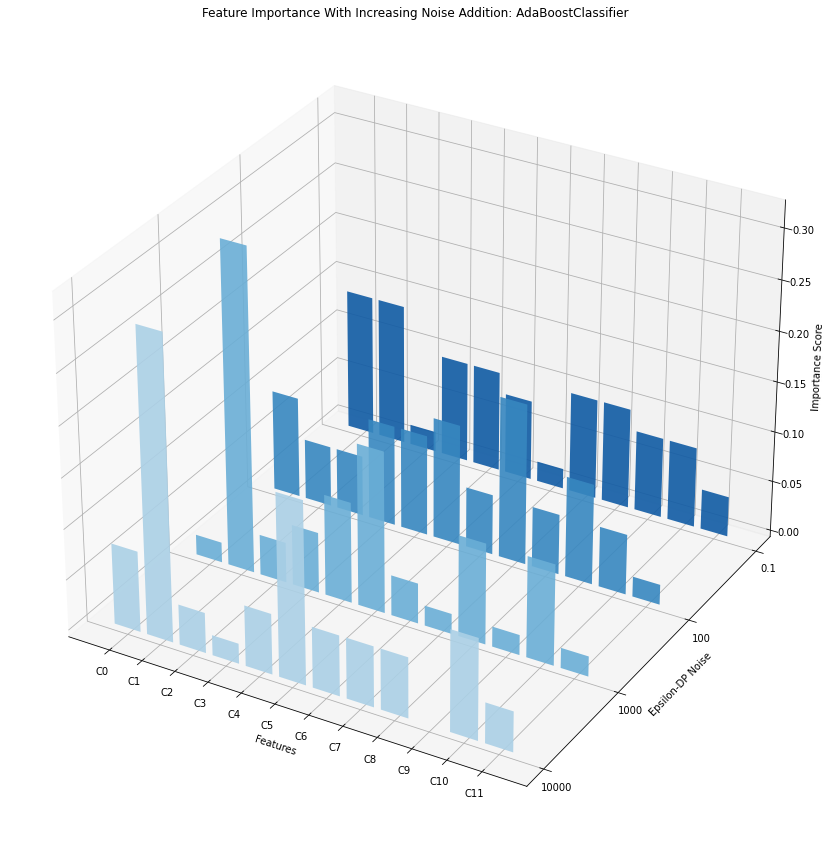

In [20]:
epsilons = [10000,1000,100,0.1]

fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')

cmap = cm.ScalarMappable(col.Normalize(-2, len(epsilons)),cm.Blues)

def add_dp_noise(x,eps):
    S = x.max(axis=0) - x.min(axis=0)
    B = S/(eps/x.shape[1])
    noise = np.random.laplace(0, B, (x.shape))
    assert x.shape == noise.shape
    x_dash = x + noise
    x_dash = x_dash.astype(np.float32)
    assert x_dash.shape == x.shape
    return x_dash

for i,epsilon  in enumerate(epsilons):

    ### ADD DP-NOISE TO COMPLETE DATASET ###
    X_train_dash = add_dp_noise(X_train,epsilon)
    # X_test_dash = add_dp_noise(X,epsilon)
    classifier = AdaBoostClassifier()
    classifier.fit(X_train_dash,y_train)
    importances = classifier.feature_importances_

    ax.bar(['C'+str(elem[0]) for elem in enumerate(list(X_train.columns))], importances, zs=i*2, zdir='y', alpha=0.9, color=cmap.to_rgba(i))

ax.set_yticks([elem*2 for elem in range(len(epsilons))])
ax.set_yticklabels(epsilons)
ax.set_xlabel('Features')
ax.set_ylabel('Epsilon-DP Noise')
ax.set_zlabel('Importance Score')
ax.set_title('Feature Importance With Increasing Noise Addition: '+str(classifier)[:-2])
plt.show()


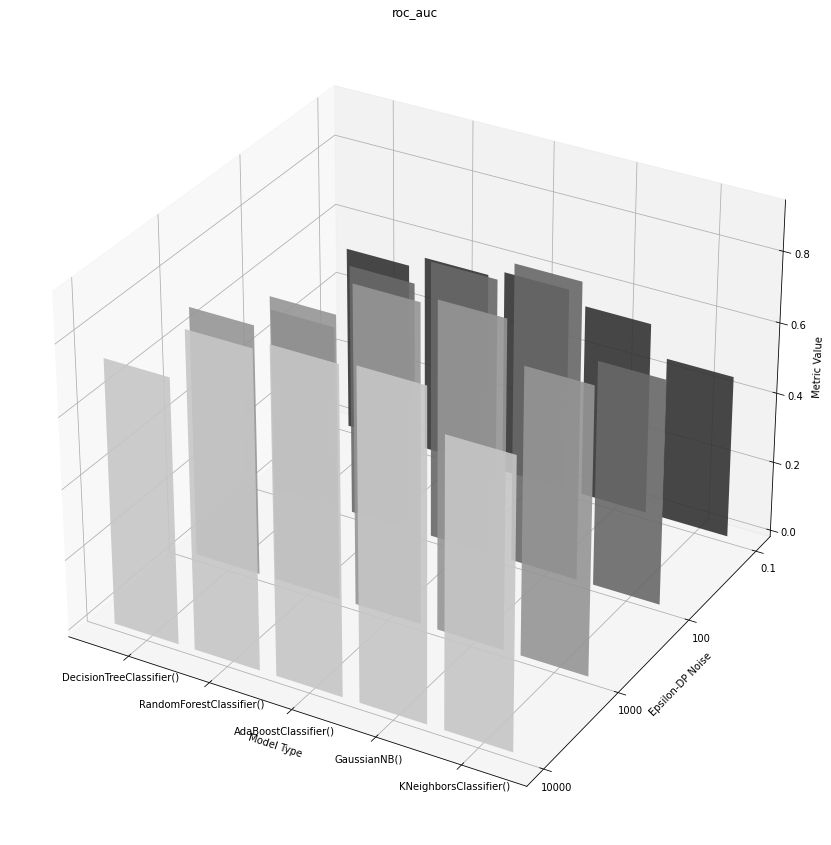

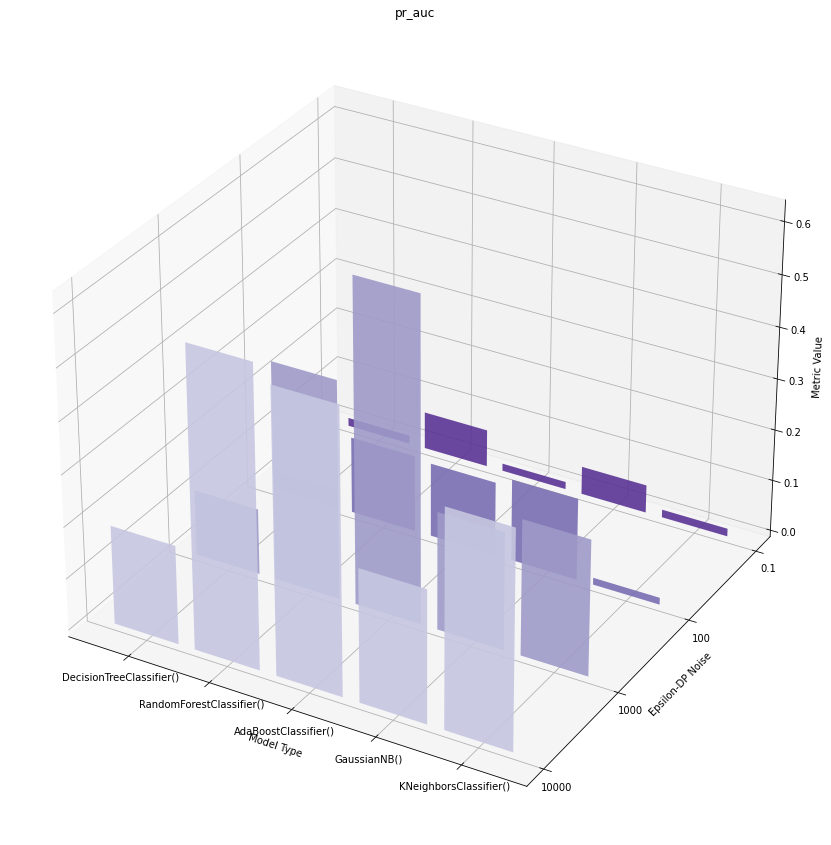

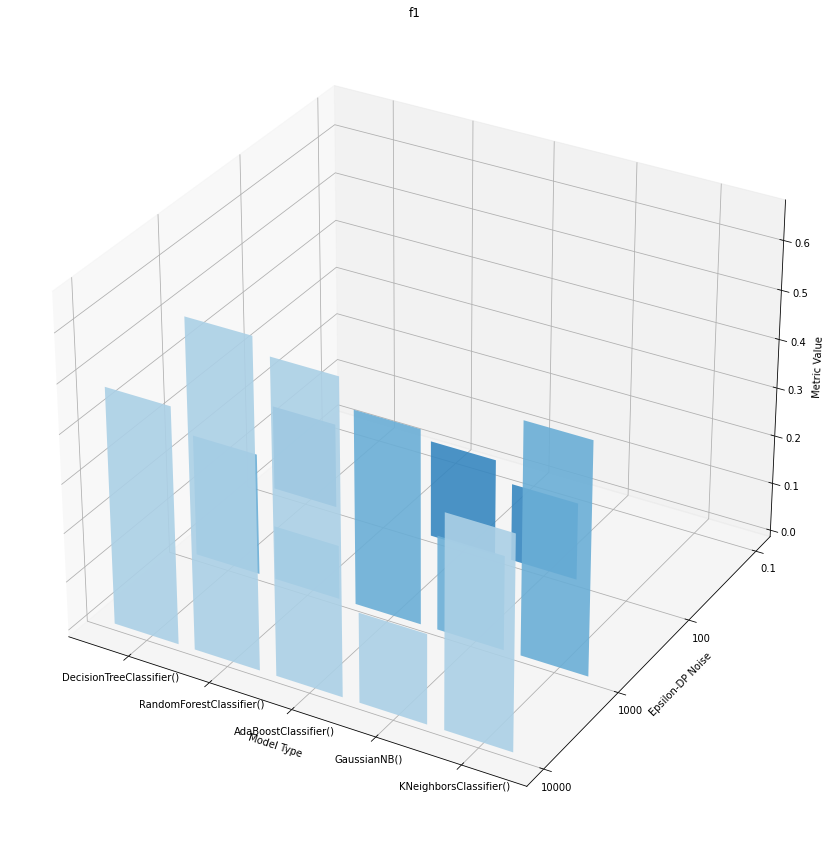

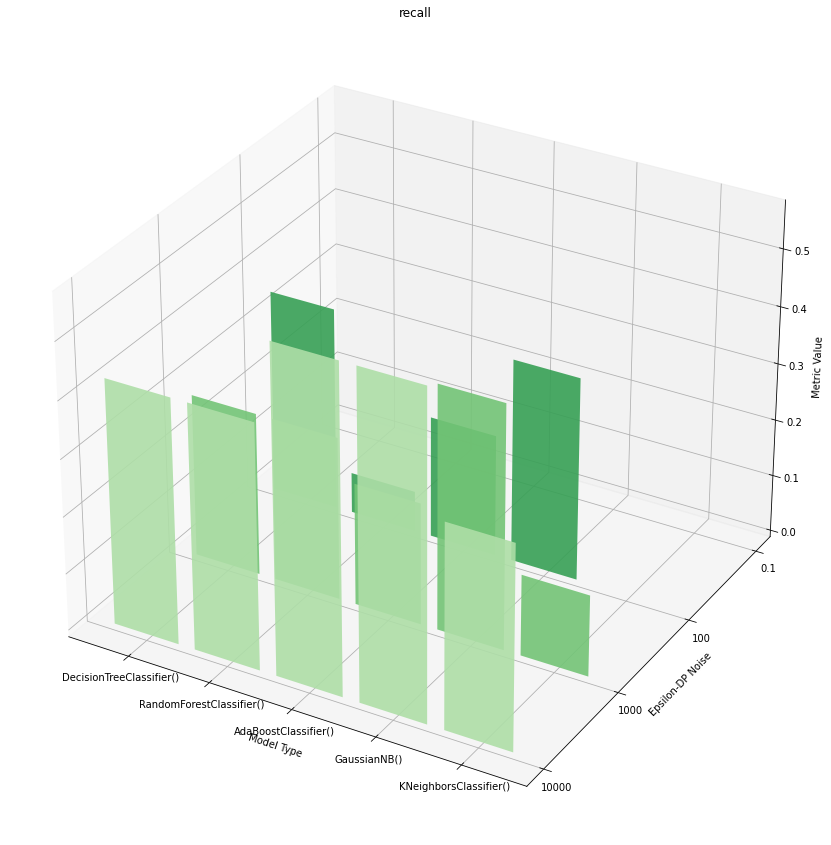

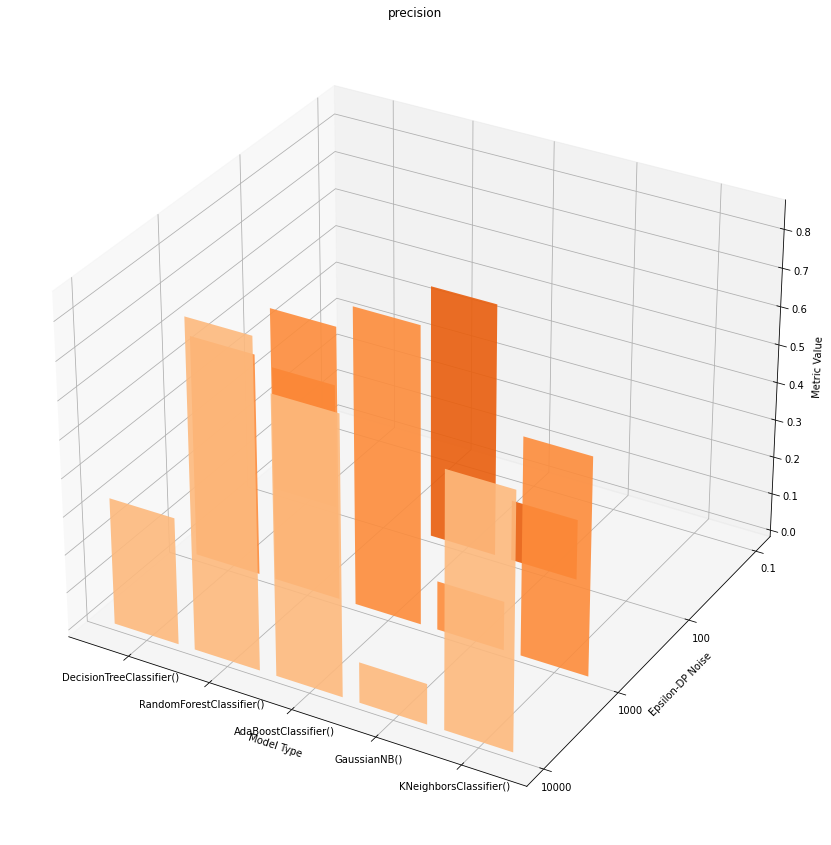

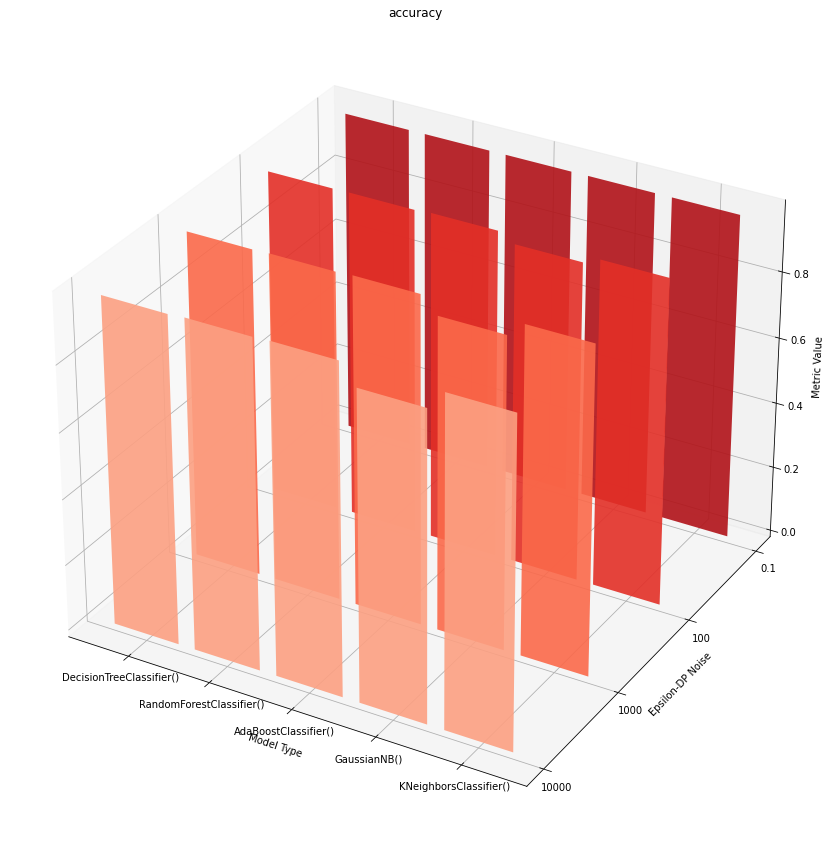

In [22]:
metrics = ['roc_auc','pr_auc','f1','recall','precision','accuracy']
classifiers = [DecisionTreeClassifier(),RandomForestClassifier(),AdaBoostClassifier(),GaussianNB(),KNeighborsClassifier()]
# classifier = classifiers[0]
epsilons = [10000,1000,100,0.1]

# [roc_auc_score(y_test,models[elem].predict(X_test)),average_precision_score(y_test,models[elem].predict(X_test)),
#                     f1_score(y_test,models[elem].predict(X_test)),recall_score(y_test,models[elem].predict(X_test)),
#                     precision_score(y_test,models[elem].predict(X_test)),accuracy_score(y_test,models[elem].predict(X_test))] 

cm_values = [cm.Greys,cm.Purples,cm.Blues,cm.Greens,cm.Oranges,cm.Reds]
cm_dict = {elem[0]:elem[1] for elem in zip(metrics,cm_values)}
def add_dp_noise(x,eps):
    S = x.max(axis=0) - x.min(axis=0)
    B = S/(eps/x.shape[1])
    noise = np.random.laplace(0, B, (x.shape))
    assert x.shape == noise.shape
    x_dash = x + noise
    x_dash = x_dash.astype(np.float32)
    assert x_dash.shape == x.shape
    return x_dash

for metric in metrics:


    fig = plt.figure(figsize=(15,15))
    ax = fig.gca(projection='3d')

    cmap = cm.ScalarMappable(col.Normalize(-2, len(epsilons)),cm_dict[metric])


    for i,epsilon  in enumerate(epsilons):

        ### ADD DP-NOISE TO COMPLETE DATASET ###
        X_train_dash = add_dp_noise(X_train,epsilon)
        X_test_dash = add_dp_noise(X_test,epsilon)
        # classifier = RandomForestClassifier()
   
        calculated_metrics = list()
        
        for classifier in classifiers: 
            classifier.fit(X_train_dash,y_train)
            y_test_pred = classifier.predict(X_test_dash)
            metric_values = [roc_auc_score(y_test,[elem[1] for elem in classifier.predict_proba(X_test_dash)]),
                            average_precision_score(y_test,[elem[1] for elem in classifier.predict_proba(X_test_dash)]),
                            f1_score(y_test,classifier.predict(X_test_dash)),
                            recall_score(y_test,classifier.predict(X_test_dash)),
                            precision_score(y_test,classifier.predict(X_test)),
                            accuracy_score(y_test,classifier.predict(X_test))] 
            metric_dict = {elem[0]:elem[1] for elem in zip(metrics,metric_values)}
            # metric = roc_auc_score(y_test,[elem[1] for elem in classifier.predict_proba(X_test_dash)])
            # print(metric_dict[metric])
            calculated_metrics.append(metric_dict[metric])
            # print(metrics)
        # tn, fp, fn, tp = confusion_matrix(y_test,y_test_pred,normalize='all').ravel()
        # print([elem for elem in confusion_matrix(y_test,y_test_pred)])
        
        
        # importances = classifier.feature_importances_
        # print(len([str(elem) for elem in classifiers]))
        # print(len([str(elem) for elem in metrics]))

        ax.bar([str(elem) for elem in classifiers], [elem for elem in calculated_metrics], zs=i*2, zdir='y', alpha=0.9, color=cmap.to_rgba(i))

    ax.set_yticks([elem*2 for elem in range(len(epsilons))])
    ax.set_yticklabels(epsilons)
    ax.set_xlabel('Model Type')
    ax.set_ylabel('Epsilon-DP Noise')
    ax.set_zlabel('Metric Value')
    ax.set_title(str(metric))
    plt.show()

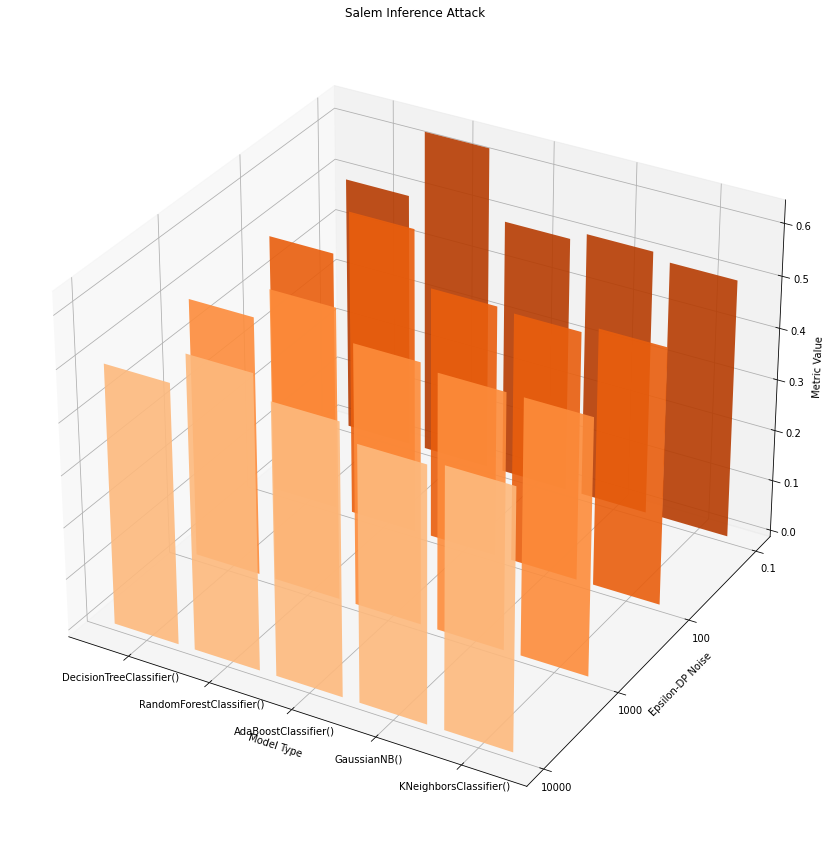

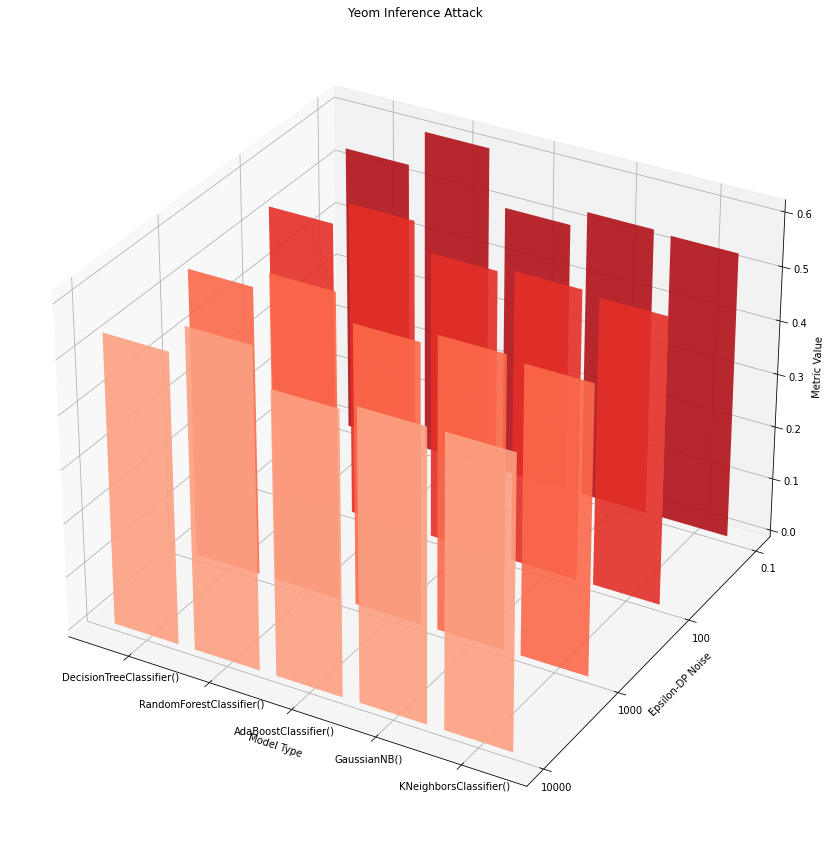

In [24]:
metrics = ['Salem Inference Attack','Yeom Inference Attack']
classifiers = [DecisionTreeClassifier(),RandomForestClassifier(),AdaBoostClassifier(),GaussianNB(),KNeighborsClassifier()]
# classifier = classifiers[0]
epsilons = [10000,1000,100,0.1]

# [roc_auc_score(y_test,models[elem].predict(X_test)),average_precision_score(y_test,models[elem].predict(X_test)),
#                     f1_score(y_test,models[elem].predict(X_test)),recall_score(y_test,models[elem].predict(X_test)),
#                     precision_score(y_test,models[elem].predict(X_test)),accuracy_score(y_test,models[elem].predict(X_test))] 

cm_values = [cm.Oranges,cm.Reds]
cm_dict = {elem[0]:elem[1] for elem in zip(metrics,cm_values)}

def add_dp_noise(x,eps):
    S = x.max(axis=0) - x.min(axis=0)
    B = S/(eps/x.shape[1])
    noise = np.random.laplace(0, B, (x.shape))
    assert x.shape == noise.shape
    x_dash = x + noise
    x_dash = x_dash.astype(np.float32)
    assert x_dash.shape == x.shape
    return x_dash


SMALL_VALUE = 0.001

def cust_log_loss(a, b):
    return [-np.log(max(b[i, a[i]], SMALL_VALUE)) for i in range(len(a))]


for metric in metrics:

    fig = plt.figure(figsize=(15,15))
    ax = fig.gca(projection='3d')

    cmap = cm.ScalarMappable(col.Normalize(-2, len(epsilons)),cm_dict[metric])


    for i,epsilon  in enumerate(epsilons):

        ### ADD DP-NOISE TO COMPLETE DATASET ###
        X_train_dash = add_dp_noise(X_train,epsilon)
        X_test_dash = add_dp_noise(X_test,epsilon)
        # classifier = RandomForestClassifier()
   
        calculated_metrics = list()

        for classifier in classifiers: 
            classifier.fit(X_train_dash,y_train)
            n_classes = len(y_test['Known Fraud'].unique())

            y_train_pred = classifier.predict(X_train_dash.values)
            y_train_pred_probs = classifier.predict_proba(X_train_dash.values)
            train_acc = accuracy_score(y_train,y_train_pred)

            train_loss = cust_log_loss(y_train.values,y_train_pred_probs)
            sk_log_loss = log_loss(y_train.values,y_train_pred_probs)

            y_test_pred = classifier.predict(X_test_dash)
            y_test_pred_probs = classifier.predict_proba(X_test_dash.values)
            test_loss = cust_log_loss(y_test.values,y_test_pred_probs)
            X_attack, y_attack = np.array([]), np.array([])
            
            X_attack = np.append(y_train_pred_probs,y_test_pred_probs,axis=0)
            y_attack = np.append(np.ones(X_train.shape[0]),np.zeros(X_test.shape[0]))
            
            # Prediction Probabilities for Complete Dataset
            X_attack = X_attack.astype('float32')
            # Binary Membership Value for Complete Dataset (1 for Training Data, 0 for Testing Data)
            y_attack = y_attack.astype('int32')
        
            if metric == metrics[0]:
                    
                fpr,tpr,thresholds = roc_curve(y_attack, X_attack[:,1], pos_label=0)
                attack_score = auc(fpr,tpr)
                # np.sum(tpr) - np.sum(fpr)
            
            if metric == metrics[1]:
                    
                loss = np.append(train_loss,test_loss)

                ls = cust_log_loss(y.values,X_attack)

                pred_membership = [1 if ls[elem] <= sk_log_loss else 0 for elem in range(len(y.values))]
                fpr, tpr, thresholds = roc_curve(y_attack, pred_membership, pos_label=0)
                attack_score = auc(tpr,fpr)
                # np.sum(tpr) - np.sum(fpr)
    
            calculated_metrics.append(attack_score)
            # metric_dict = {elem[0]:elem[1] for elem in zip(metrics,metric_values)}
            # calculated_metrics.append(metric_dict[metric])
   
        ax.bar([str(elem) for elem in classifiers], [elem for elem in calculated_metrics], zs=i*2, zdir='y', alpha=0.9, color=cmap.to_rgba(i))

    ax.set_yticks([elem*2 for elem in range(len(epsilons))])
    ax.set_yticklabels(epsilons)
    ax.set_xlabel('Model Type')
    ax.set_ylabel('Epsilon-DP Noise')
    ax.set_zlabel('Metric Value')
    ax.set_title(str(metric))
    plt.show()

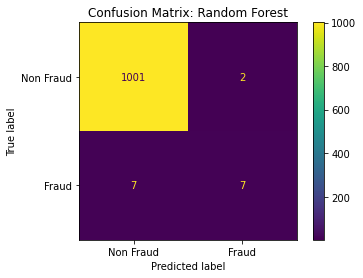

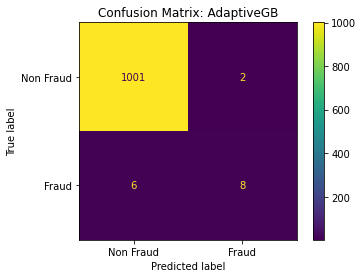

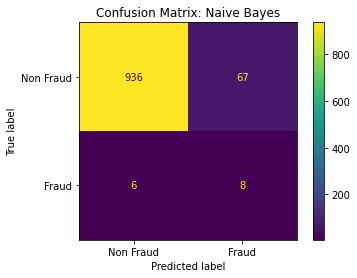

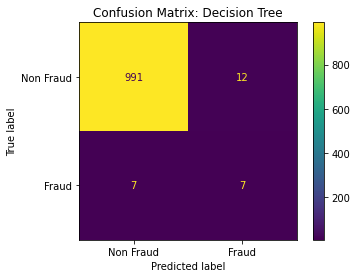

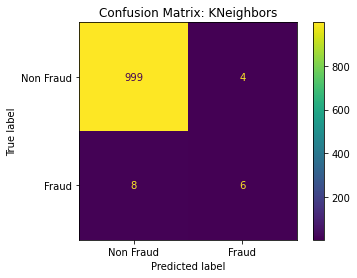

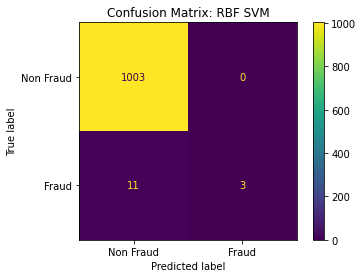

In [21]:
# plt.subplot(1,2,1)

for elem in models.keys():
    plot_confusion_matrix(models[elem], X_test, y_test, display_labels=['Non Fraud','Fraud'])
    plt.title('Confusion Matrix: '+str(elem))


# # plt.subplot(1,2,2)
# plot_confusion_matrix(nb, X_test, y_test, display_labels=['Non Fraud','Fraud'])


# plot_confusion_matrix(ada, X_test, y_test, display_labels=['Non Fraud','Fraud'])

# plot_confusion_matrix(dt, X_test, y_test, display_labels=['Non Fraud','Fraud'])



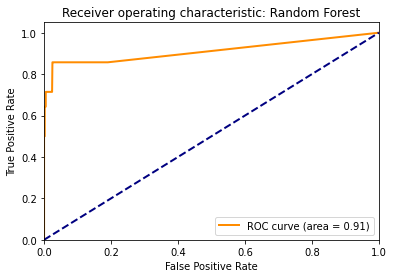

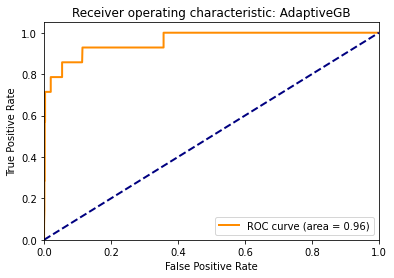

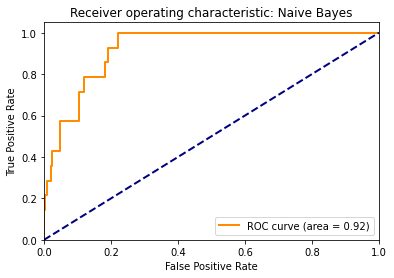

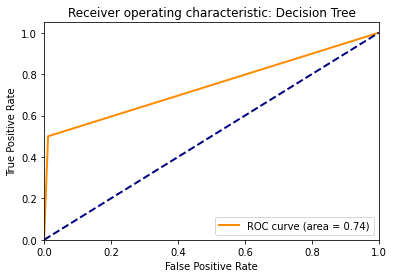

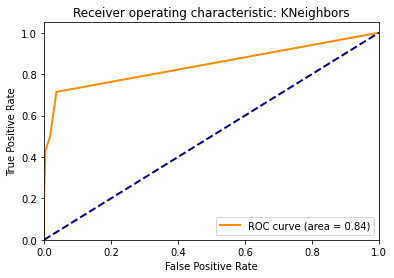

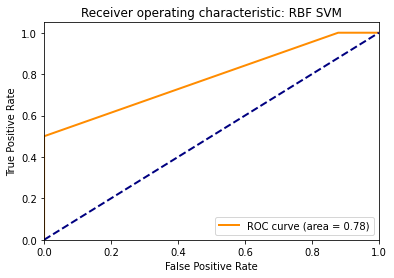

In [22]:
for elem in models.keys():

    # Compute ROC curve and ROC area for each class
    fpr = dict()

    tpr = dict()
    roc_auc = dict()

    fpr, tpr, _ = roc_curve(pd.get_dummies(y_test).values[:], models[elem].predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)

    # plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic: "+str(elem))
    plt.legend(loc="lower right")
    # time.sleep(2)
    plt.show()


In [27]:


res_df = pd.DataFrame()
res_df['Performance Metrics'] = ['ROC_AUC','PR_AUC','F1','RECALL','PRECISION','ACCURACY']

# models = {'Random Forest': rf,'AdaptiveGB':ada,'Naive Bayes':nb,'Decision Tree':dt}
for elem in models.keys():
    res_df[elem] = [roc_auc_score(y_test,models[elem].predict(X_test)),average_precision_score(y_test,models[elem].predict(X_test)),
                    f1_score(y_test,models[elem].predict(X_test)),recall_score(y_test,models[elem].predict(X_test)),
                    precision_score(y_test,models[elem].predict(X_test)),accuracy_score(y_test,models[elem].predict(X_test))] 

res_df[['Performance Metrics','Decision Tree','Random Forest','AdaptiveGB']]

# print('ROC AUC', roc_auc_score(y_train, y_pred_train), roc_auc_score(y_test, y_pred_test))
# print('PR AUC', average_precision_score(y_train, y_pred_train), average_precision_score(y_test, y_pred_test))
# print('F1', f1_score(y_train, y_pred_train), f1_score(y_test, y_pred_test))
# print('Recall', recall_score(y_train, y_pred_train), recall_score(y_test, y_pred_test))
# print('Precision', precision_score(y_train, y_pred_train), precision_score(y_test, y_pred_test))
# print('Accuracy', accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test))

,Performance Metrics,Decision Tree,Random Forest,AdaptiveGB
0,ROC_AUC,0.744018,0.749003,0.784717
1,PR_AUC,0.191094,0.395772,0.463043
2,F1,0.424242,0.608696,0.666667
3,RECALL,0.500000,0.500000,0.571429
4,PRECISION,0.368421,0.777778,0.800000
5,ACCURACY,0.981318,0.991150,0.992134


In [24]:
def add_dp_noise(x,eps):
    S = x.max(axis=0) - x.min(axis=0)
    B = S/(eps/x.shape[1])
    noise = np.random.laplace(0, B, (x.shape))
    assert x.shape == noise.shape
    x_dash = x + noise
    x_dash = x_dash.astype(np.float32)
    assert x_dash.shape == x.shape
    return x_dash

SMALL_VALUE = 0.001

def cust_log_loss(a, b):
    return [-np.log(max(b[i, a[i]], SMALL_VALUE)) for i in range(len(a))]

In [54]:
X_train.columns = ['Column'+str(elem[1]) for elem in zip(X_train.columns[:],range(len(X_train.columns[:])))]
X_train[X_train.columns[:11]].head(3)
add_dp_noise(X_train[X_train.columns[:11]].head(3),1000)
add_dp_noise(X_train[X_train.columns[:11]].head(3),100)
add_dp_noise(X_train[X_train.columns[:11]].head(3),10)
add_dp_noise(X_train[X_train.columns[:11]].head(3),0.1)



In [ ]:


res_df
data = res_df.set_index(res_df['Performance Metrics'],drop=True)
del data['Performance Metrics']
data

for metric in data.index:        

        fig,ax = plt.subplots()
        plt.title(str(metric))
        plt.xticks(rotation=90)

        plt.figure(figsize=(12,5))

        
        ax.bar([elem for elem in data.columns],data.loc['ROC_AUC'].values,label=['ROC_AUC'],
                color=['green','darkgreen','lightblue','lightgreen','purple','brown'])
        
        # ax.legend()

Classifier: Random Forest
Varying DP Noise Applied at Stage:
1 (Before Model Training
epsilon salem_mi yeom_mi test_acc_loss
0.01 0.0 0.259 0.0
0.05 0.0 0.256 0.0
0.1 0.0 0.275 0.0
0.5 0.0 0.258 0.0
1 0.0 0.265 0.0
5 0.0 0.253 0.0
10 0.0 0.254 0.0
50 0.0 0.195 0.0
100 0.0 0.169 0.01
500 0.0 0.162 0.0
1000 0.0 0.164 0.0
Classifier: AdaptiveGB
Varying DP Noise Applied at Stage:
1 (Before Model Training
epsilon salem_mi yeom_mi test_acc_loss
0.01 0.0 0.033 0.01
0.05 0.0 0.043 0.01
0.1 0.0 0.036 0.01
0.5 -0.0 0.033 0.01
1 0.0 0.029 0.01
5 -0.0 0.029 0.01
10 -0.0 0.031 0.01
50 -0.0 0.032 0.01
100 0.0 0.025 0.01
500 0.0 0.056 0.01
1000 0.0 0.065 0.0
Classifier: Naive Bayes
Varying DP Noise Applied at Stage:
1 (Before Model Training
epsilon salem_mi yeom_mi test_acc_loss
0.01 0.0 0.079 -0.06
0.05 0.0 0.084 -0.06
0.1 0.0 0.085 -0.06
0.5 0.0 0.081 -0.06
1 0.0 0.078 -0.06
5 0.0 0.082 -0.06
10 0.0 0.081 -0.06
50 0.0 0.075 -0.05
100 0.0 0.075 -0.04
500 -0.0 0.083 -0.02
1000 -0.0 0.088 -0.01
Classi

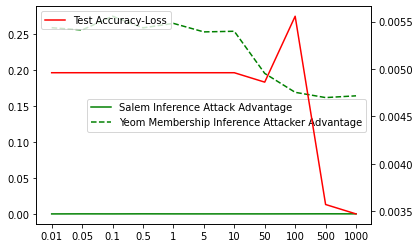

<Figure size 720x360 with 0 Axes>

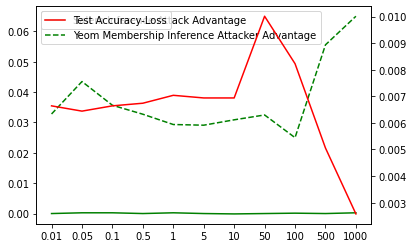

<Figure size 720x360 with 0 Axes>

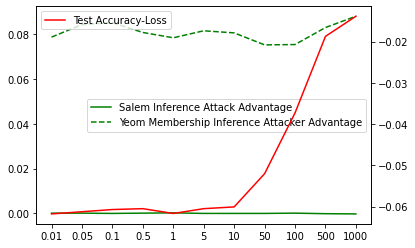

<Figure size 720x360 with 0 Axes>

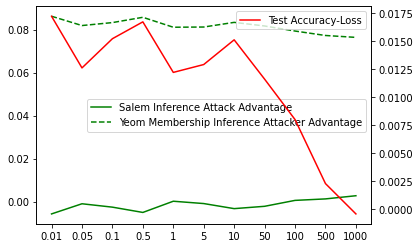

<Figure size 720x360 with 0 Axes>

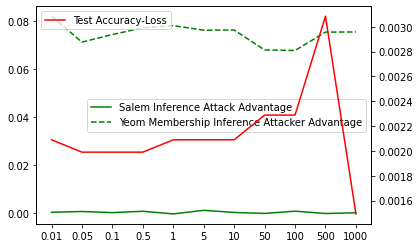

<Figure size 720x360 with 0 Axes>

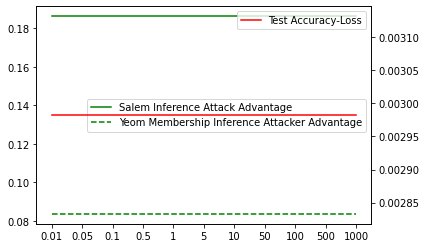

<Figure size 720x360 with 0 Axes>

In [68]:
### COMPLETE EXPERIMENT TENTATIVE ###

### DEFINE PARAMETERS ###
non_fitted_models = {'Random Forest': RandomForestClassifier(random_state=42),
 'AdaptiveGB': AdaBoostClassifier(random_state=42),
 'Naive Bayes': GaussianNB(),
 'Decision Tree': DecisionTreeClassifier(random_state=42),
 'KNeighbors': KNeighborsClassifier(),
 'RBF SVM': SVC(C=1, gamma=2, probability=True)}



# add_s1_noise = False
### default not used when previous value set to True ###
# default_noise_value = 100
# use_non_dp_defaults = True

# X_train, X_test, y_train, y_test = train_test_split(asset_location_data[classifier_input],asset_location_data[classifier_target], test_size=0.2,random_state=50)
# X = X_train.append(X_test)
# y = y_train.append(y_test)

for model in list(non_fitted_models.keys()):


    epsilons = [0.01,0.05,0.1,0.5,1,5,10,50,100,500,1000]
    rounds = 10
    model_type = model


    print('Classifier: '+str(model_type))
    print('Varying DP Noise Applied at Stage:')
    # if add_s1_noise is True:
    print('1 (Before Model Training')
    # if add_s1_noise is False:
    #     print('2 (During Model Training')


    print('epsilon','salem_mi','yeom_mi','test_acc_loss')

    salem_mis = list()
    yeom_mis = list()
    test_accs = list()

    ### RUN FOR LOOP TO GENERATE PERFORMANCE & PRIVACY METRICS FOR DIFFERENT PRIVACY BUDGETS ###
    for epsilon  in epsilons:
        salem_mi = 0 
        yeom_mi = 0
        test_acc = 0

        for i in range(rounds):

            # dp_model_list = {'lr':DPLogisticRegression(epsilon=epsilon),
            #              'nb':DPGaussianNB(epsilon=epsilon),
            #              'rf':DPRandomForestClassifier(epsilon=epsilon)
            #             }
            # if use_non_dp_defaults is True:
            #     non_dp_model_list = {'lr':LogisticRegression(),
            #                     'nb':GaussianNB(),
            #                     'rf':RandomForestClassifier()
            #                     }
            # if use_non_dp_defaults is False:
            #     non_dp_model_list = {'lr':LogisticRegression(epsilon=10000),
            #                     'nb':GaussianNB(epsilon=10000),
            #                     'rf':RandomForestClassifier(epsilon=10000)
            #                     }
            # # assert model_type in dp_model_list.keys() and non_dp_model_list.keys()


            # dp_classifier = dp_model_list[model_type]
            # non_dp_classifier = non_dp_model_list[model_type]


            # if add_s1_noise is True:    
            ### ADD DP-NOISE TO COMPLETE DATASET ###
            X_train_dash = add_dp_noise(X_train,epsilon)
            X_test_dash = add_dp_noise(X_test,epsilon)
            classifier = copy.deepcopy(non_fitted_models[model_type])

            # if add_s1_noise is False:

            #     X_train_dash = add_dp_noise(X_train,default_noise_value)
            #     X_test_dash = add_dp_noise(X_test,default_noise_value)
            #     classifier = copy.deepcopy(non_fitted_models[model_type])


            n_classes = len(y_test['Known Fraud'].unique())


            classifier.fit(X_train_dash,y_train)
            y_train_pred = classifier.predict(X_train_dash.values)
            y_train_pred_probs = classifier.predict_proba(X_train_dash.values)
            train_acc = accuracy_score(y_train,y_train_pred)
            

            train_loss = cust_log_loss(y_train.values,y_train_pred_probs)
            sk_log_loss = log_loss(y_train.values,y_train_pred_probs)

            y_test_pred = classifier.predict(X_test_dash)
            y_test_pred_probs = classifier.predict_proba(X_test_dash.values)
            test_acc = test_acc + (1-(accuracy_score(y_test,y_test_pred)/accuracy_score(y_test,copy.deepcopy(non_fitted_models[model_type]).fit(X_train,y_train).predict(X_test))))
            test_loss = cust_log_loss(y_test.values,y_test_pred_probs)
            X_attack, y_attack = np.array([]), np.array([])

            
            X_attack = np.append(y_train_pred_probs,y_test_pred_probs,axis=0)
            y_attack = np.append(np.ones(X_train.shape[0]),np.zeros(X_test.shape[0]))

            # Prediction Probabilities for Complete Dataset
            X_attack = X_attack.astype('float32')
            # Binary Membership Value for Complete Dataset (1 for Training Data, 0 for Testing Data)
            y_attack = y_attack.astype('int32')

            
            fpr,tpr,thresholds = roc_curve(y_attack, X_attack[:,1], pos_label=1)
            salem_mi = salem_mi + (tpr[1] + tpr[0] -fpr[0]-fpr[1])
            # auc(tpr,fpr)

            loss = np.append(train_loss,test_loss)

            ls = cust_log_loss(y.values,X_attack)

            pred_membership = [1 if ls[elem] <= sk_log_loss else 0 for elem in range(len(y.values))]
            fpr, tpr, thresholds = roc_curve(y_attack, pred_membership, pos_label=1)
            yeom_mi = yeom_mi +( tpr[1] + tpr[0] -fpr[1] -fpr[0])
            # tpr[1]-fpr[1]
            

            attr_adv, attr_mem, attr_pred = [], [], []

            # for feature in features:
                


            
            # print(epsilon,round(salem_mi,3),round(yeom_mi,3),round(test_acc,2))
        
        salem_mi = salem_mi/rounds
        yeom_mi = yeom_mi/rounds
        test_acc = test_acc/rounds

        print(epsilon,round(salem_mi,3),round(yeom_mi,3),round(test_acc,2))

        salem_mis.append(salem_mi)
        yeom_mis.append(yeom_mi)
        test_accs.append(test_acc)


    fig,ax = plt.subplots()
    plt.figure(figsize=(10,5))

    ax2 = ax.twinx()

    ax.plot([str(elem) for elem in epsilons],salem_mis,label='Salem Inference Attack Advantage',color='green')
    ax.plot([str(elem) for elem in epsilons],yeom_mis,label='Yeom Membership Inference Attacker Advantage',color='green',linestyle='dashed')
    # ax.plot([str(elem) for elem in epsilons],np.ones(len(epsilons)),label='Attribute Inference Attack Advantage')
    ax2.plot([str(elem) for elem in epsilons],test_accs,label='Test Accuracy-Loss',color='red')

    ax.legend()
    ax2.legend()
    # plt.semilogx(epsilons, accuracy)
    # plt.yscale('symlog')
    # ax.title("Performance-Privacy Tradeoff")
    # ax.xlabel("epsilon")
    # ax.ylabel("Score")

In [72]:
for col in res_df.columns[1:]:
    res_df[col] = [round(elem,3) for elem in res_df[col]]

In [73]:
res_df.to_csv('res_au.csv')

In [102]:
for epsilon in [1000,100,10,0.1]:

    df_dp = add_dp_noise(X_train.reset_index(drop=True).head(9),epsilon)

    for col in df_dp.columns:
        df_dp[col] = [round(elem,0) for elem in df_dp[col]]

    df_dp.columns = [elem[0]+elem[6:] for elem in df_dp.columns]

    

    df_dp.to_csv('df_dp_'+str(epsilon)+'_au.csv')

In [105]:
df_dp[df_dp.columns[:-1]].to_csv('df_dp_0.1_au.csv')

In [92]:
df = X_train.reset_index(drop=True).head(9)
# .to_csv('df_au.csv')

In [81]:

for col in ['Column11']:
    df[col] = [round(elem,3) for elem in df[col]]

In [93]:
df.columns = [elem[0]+elem[6:] for elem in df.columns]

In [95]:
df.to_csv('df_au.csv')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib

matplotlib.use('agg')
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Arial'

import operator
import math
from scipy.stats import wilcoxon
from scipy.stats import friedmanchisquare
import networkx

# inspired from orange3 https://docs.orange.biolab.si/3/data-mining-library/reference/evaluation.cd.html
def graph_ranks(avranks, names, p_values, cd=None, cdmethod=None, lowv=None, highv=None,
                width=6, textspace=1, reverse=False, filename=None, labels=False, **kwargs):
    """
    Draws a CD graph, which is used to display  the differences in methods'
    performance. See Janez Demsar, Statistical Comparisons of Classifiers over
    Multiple Data Sets, 7(Jan):1--30, 2006.

    Needs matplotlib to work.

    The image is ploted on `plt` imported using
    `import matplotlib.pyplot as plt`.

    Args:
        avranks (list of float): average ranks of methods.
        names (list of str): names of methods.
        cd (float): Critical difference used for statistically significance of
            difference between methods.
        cdmethod (int, optional): the method that is compared with other methods
            If omitted, show pairwise comparison of methods
        lowv (int, optional): the lowest shown rank
        highv (int, optional): the highest shown rank
        width (int, optional): default width in inches (default: 6)
        textspace (int, optional): space on figure sides (in inches) for the
            method names (default: 1)
        reverse (bool, optional):  if set to `True`, the lowest rank is on the
            right (default: `False`)
        filename (str, optional): output file name (with extension). If not
            given, the function does not write a file.
        labels (bool, optional): if set to `True`, the calculated avg rank
        values will be displayed
    """
    try:
        import matplotlib
        import matplotlib.pyplot as plt
        from matplotlib.backends.backend_agg import FigureCanvasAgg
    except ImportError:
        raise ImportError("Function graph_ranks requires matplotlib.")

    width = float(width)
    textspace = float(textspace)

    def nth(l, n):
        """
        Returns only nth elemnt in a list.
        """
        n = lloc(l, n)
        return [a[n] for a in l]

    def lloc(l, n):
        """
        List location in list of list structure.
        Enable the use of negative locations:
        -1 is the last element, -2 second last...
        """
        if n < 0:
            return len(l[0]) + n
        else:
            return n

    def mxrange(lr):
        """
        Multiple xranges. Can be used to traverse matrices.
        This function is very slow due to unknown number of
        parameters.

        >>> mxrange([3,5])
        [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

        >>> mxrange([[3,5,1],[9,0,-3]])
        [(3, 9), (3, 6), (3, 3), (4, 9), (4, 6), (4, 3)]

        """
        if not len(lr):
            yield ()
        else:
            # it can work with single numbers
            index = lr[0]
            if isinstance(index, int):
                index = [index]
            for a in range(*index):
                for b in mxrange(lr[1:]):
                    yield tuple([a] + list(b))

    def print_figure(fig, *args, **kwargs):
        canvas = FigureCanvasAgg(fig)
        canvas.print_figure(*args, **kwargs)

    sums = avranks

    nnames = names
    ssums = sums

    if lowv is None:
        lowv = min(1, int(math.floor(min(ssums))))
    if highv is None:
        highv = max(len(avranks), int(math.ceil(max(ssums))))

    cline = 0.4

    k = len(sums)

    lines = None

    linesblank = 0
    scalewidth = width - 2 * textspace

    def rankpos(rank):
        if not reverse:
            a = rank - lowv
        else:
            a = highv - rank
        return textspace + scalewidth / (highv - lowv) * a

    distanceh = 0.25

    cline += distanceh

    # calculate height needed height of an image
    minnotsignificant = max(2 * 0.2, linesblank)
    height = cline + ((k + 1) / 2) * 0.2 + minnotsignificant

    fig = plt.figure(figsize=(width, height))
    fig.set_facecolor('white')
    ax = fig.add_axes([0, 0, 1, 1])  # reverse y axis
    ax.set_axis_off()

    hf = 1. / height  # height factor
    wf = 1. / width

    def hfl(l):
        return [a * hf for a in l]

    def wfl(l):
        return [a * wf for a in l]

    # Upper left corner is (0,0).
    ax.plot([0, 1], [0, 1], c="w")
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)

    def line(l, color='k', **kwargs):
        """
        Input is a list of pairs of points.
        """
        ax.plot(wfl(nth(l, 0)), hfl(nth(l, 1)), color=color, **kwargs)

    def text(x, y, s, *args, **kwargs):
        ax.text(wf * x, hf * y, s, *args, **kwargs)

    line([(textspace, cline), (width - textspace, cline)], linewidth=2)

    bigtick = 0.3
    smalltick = 0.15
    linewidth = 2.0
    linewidth_sign = 4.0

    tick = None
    for a in list(np.arange(lowv, highv, 0.5)) + [highv]:
        tick = smalltick
        if a == int(a):
            tick = bigtick
        line([(rankpos(a), cline - tick / 2),
              (rankpos(a), cline)],
             linewidth=2)

    for a in range(lowv, highv + 1):
        text(rankpos(a), cline - tick / 2 - 0.05, str(a),
             ha="center", va="bottom", size=16)

    k = len(ssums)

    def filter_names(name):
        return name

    space_between_names = 0.24

    for i in range(math.ceil(k / 2)):
        chei = cline + minnotsignificant + i * space_between_names
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace - 0.1, chei)],
             linewidth=linewidth)
        if labels:
            text(textspace + 0.3, chei - 0.075, format(ssums[i], '.4f'), ha="right", va="center", size=10)
        text(textspace - 0.2, chei, filter_names(nnames[i]), ha="right", va="center", size=16)

    for i in range(math.ceil(k / 2), k):
        chei = cline + minnotsignificant + (k - i - 1) * space_between_names
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace + scalewidth + 0.1, chei)],
             linewidth=linewidth)
        if labels:
            text(textspace + scalewidth - 0.3, chei - 0.075, format(ssums[i], '.4f'), ha="left", va="center", size=10)
        text(textspace + scalewidth + 0.2, chei, filter_names(nnames[i]),
             ha="left", va="center", size=16)

    # no-significance lines
    def draw_lines(lines, side=0.05, height=0.1):
        start = cline + 0.2

        for l, r in lines:
            line([(rankpos(ssums[l]) - side, start),
                  (rankpos(ssums[r]) + side, start)],
                 linewidth=linewidth_sign)
            start += height
            print('drawing: ', l, r)

    # draw_lines(lines)
    start = cline + 0.2
    side = -0.02
    height = 0.1

    # draw no significant lines
    # get the cliques
    cliques = form_cliques(p_values, nnames)
    i = 1
    achieved_half = False
    print(nnames)
    for clq in cliques:
        if len(clq) == 1:
            continue
        print(clq)
        min_idx = np.array(clq).min()
        max_idx = np.array(clq).max()
        if min_idx >= len(nnames) / 2 and achieved_half == False:
            start = cline + 0.25
            achieved_half = True
        line([(rankpos(ssums[min_idx]) - side, start),
              (rankpos(ssums[max_idx]) + side, start)],
             linewidth=linewidth_sign)
        start += height


def form_cliques(p_values, nnames):
    """
    This method forms the cliques
    """
    # first form the numpy matrix data
    m = len(nnames)
    g_data = np.zeros((m, m), dtype=np.int64)
    for p in p_values:
        if p[3] == False:
            i = np.where(nnames == p[0])[0][0]
            j = np.where(nnames == p[1])[0][0]
            min_i = min(i, j)
            max_j = max(i, j)
            g_data[min_i, max_j] = 1

    g = networkx.Graph(g_data)
    return networkx.find_cliques(g)


def draw_cd_diagram(df_perf=None, alpha=0.05, title=None, labels=False):
    """
    Draws the critical difference diagram given the list of pairwise classifiers that are
    significant or not
    """
    p_values, average_ranks, _ = wilcoxon_holm(df_perf=df_perf, alpha=alpha)

    print(average_ranks)

    for p in p_values:
        print(p)


    graph_ranks(average_ranks.values, average_ranks.keys(), p_values,
                cd=None, reverse=True, width=9, textspace=1.5, labels=labels)

    font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 22,
        }
    if title:
        plt.title(title,fontdict=font, y=0.9, x=0.5)
    plt.savefig('cd-diagram.png',bbox_inches='tight')


def wilcoxon_holm(alpha=0.05, df_perf=None):
    """
    Applies the wilcoxon signed rank test between each pair of algorithm and then use Holm
    to reject the null's hypothesis
    """
    print(pd.unique(df_perf['classifier_name']))
    # count the number of tested datasets per classifier
    df_counts = pd.DataFrame({'count': df_perf.groupby(
        ['classifier_name']).size()}).reset_index()
    # get the maximum number of tested datasets
    max_nb_datasets = df_counts['count'].max()
    # get the list of classifiers who have been tested on nb_max_datasets
    classifiers = list(df_counts.loc[df_counts['count'] == max_nb_datasets]
                       ['classifier_name'])
    # test the null hypothesis using friedman before doing a post-hoc analysis
    friedman_p_value = friedmanchisquare(*(
        np.array(df_perf.loc[df_perf['classifier_name'] == c]['accuracy'])
        for c in classifiers))[1]
    if friedman_p_value >= alpha:
        # then the null hypothesis over the entire classifiers cannot be rejected
        print('the null hypothesis over the entire classifiers cannot be rejected')
        exit()
    # get the number of classifiers
    m = len(classifiers)
    # init array that contains the p-values calculated by the Wilcoxon signed rank test
    zp_values = []
    # loop through the algorithms to compare pairwise
    for i in range(m - 1):
        # get the name of classifier one
        classifier_1 = classifiers[i]
        # get the performance of classifier one
        perf_1 = np.array(df_perf.loc[df_perf['classifier_name'] == classifier_1]['accuracy']
                          , dtype=np.float64)
        for j in range(i + 1, m):
            # get the name of the second classifier
            classifier_2 = classifiers[j]
            # get the performance of classifier one
            perf_2 = np.array(df_perf.loc[df_perf['classifier_name'] == classifier_2]
                              ['accuracy'], dtype=np.float64)
            # calculate the p_value
            p_value = wilcoxon(perf_1, perf_2, zero_method='pratt')[1]
            # appen to the list
            p_values.append((classifier_1, classifier_2, p_value, False))
    # get the number of hypothesis
    k = len(p_values)
    # sort the list in acsending manner of p-value
    p_values.sort(key=operator.itemgetter(2))

    # loop through the hypothesis
    for i in range(k):
        # correct alpha with holm
        new_alpha = float(alpha / (k - i))
        # test if significant after holm's correction of alpha
        if p_values[i][2] <= new_alpha:
            p_values[i] = (p_values[i][0], p_values[i][1], p_values[i][2], True)
        else:
            # stop
            break
    # compute the average ranks to be returned (useful for drawing the cd diagram)
    # sort the dataframe of performances
    sorted_df_perf = df_perf.loc[df_perf['classifier_name'].isin(classifiers)]. \
        sort_values(['classifier_name', 'dataset_name'])
    # get the rank data
    rank_data = np.array(sorted_df_perf['accuracy']).reshape(m, max_nb_datasets)

    # create the data frame containg the accuracies
    df_ranks = pd.DataFrame(data=rank_data, index=np.sort(classifiers), columns=
    np.unique(sorted_df_perf['dataset_name']))

    # number of wins
    dfff = df_ranks.rank(ascending=False)
    print(dfff[dfff == 1.0].sum(axis=1))

    # average the ranks
    average_ranks = df_ranks.rank(ascending=False).mean(axis=1).sort_values(ascending=False)
    # return the p-values and the average ranks
    return p_values, average_ranks, max_nb_datasets




In [ ]:
df_perf = pd.read_csv('res_cd_F1.csv')[pd.read_csv('res_cd_F1.csv').columns[1:]]

# ,index_col=False
draw_cd_diagram(df_perf=df_perf, title='F1 Score', labels=True)


['Random Forest' 'AdaptiveGB' 'Naive Bayes' 'Decision Tree' 'KNeighbors'
 'RBF SVM']
the null hypothesis over the entire classifiers cannot be rejected


NameError: name 'p_values' is not defined